In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io,morphology
import time

/usr/local/lib/python2.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


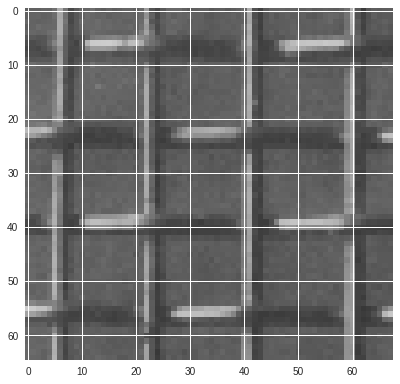

(65, 68)


In [6]:
SampleImage = io.imread('/content/gdrive/My Drive/Colab Notebooks/T1.gif')
io.imshow(SampleImage)
io.show()

WindowSize = 11
ErrThreshold = 0.1
MaxErrThreshold = 0.3
Sigma = WindowSize/6.4

SampleImage = SampleImage.astype(float)/255

print(SampleImage.shape)

In [0]:
def Gaussian2D(shape=(3,3),sigma=0.5):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [0]:
def GetValidMask(Template):
    r,c = Template.shape
    ValidMask = np.zeros([r,c])
    for i in range(r):
        for j in range(c):
            if Template[i][j] > 0:
                ValidMask[i][j] = 1
    return ValidMask

In [0]:
def FindMatches(Template,SampleImage,imageWindow):
    r,c = SampleImage.shape
    n = WindowSize/2
    SSD = []
    pixelValue = []
    ValidMask = GetValidMask(Template)
    #print(ValidMask.shape)
    GaussMask = Gaussian2D((WindowSize,WindowSize),Sigma)
    Template = np.reshape(Template, WindowSize**2)
    GaussMask = np.reshape(GaussMask, WindowSize**2)
    ValidMask = np.reshape(ValidMask, WindowSize**2)
    TotWeight = np.sum(np.multiply(GaussMask, ValidMask))
    distance = (imageWindow-Template)**2
    SSD = np.sum((distance*GaussMask*ValidMask) / TotWeight, axis=1)
    #print(TotWeight)
#    for i in range(n, r-n-1):
#        for j in range(n,c-n-1):
#          dist = (Template-SampleImage[i-n:i+n+1, j-n:j+n+1])**2
#          SSD.append(np.sum(dist * GaussMask * ValidMask) / TotWeight)
#          pixelValue.append(SampleImage[i][j])
          
    PixelList = []
    minErrThres = np.min(SSD)*(1+ErrThreshold)
    mid = (WindowSize**2) / 2;
    for i in range(len(SSD)):
        if SSD[i]<=minErrThres:
            PixelList.append((SSD[i], imageWindow[i][mid]))
    if len(PixelList)==0:
      PixelList.append((np.min(SSD),imageWindow[0][mid]))
    return PixelList


In [0]:
def GetNeighborhoodWindow(Pixel,WindowSize):
    r,c = Pixel
    #n = WindowSize/2
    #paddedImage = cv2.copyMakeBorder(Image,n,n,n,n,cv2.BORDER_REFLECT)
    return paddedImage[r:r+WindowSize, c:c+WindowSize]

In [0]:
def GetUnfilledNeighbors(Image):
    r,c = Image.shape
    PixelList = []
    for i in range(r):
        for j in range(c):
            if Image[i][j] == 0:
                PixelList.append((i,j))
    return PixelList

In [0]:
def RandomPick(BestMatches):
    return BestMatches[np.random.randint(len(BestMatches))]

In [0]:
def isNotFilled(Image):
    r,c = Image.shape
    for i in range(r):
        for j in range(c):
            if Image[i][j] == 0:
                return True
    return False

In [0]:
def GrowImage(SampleImage,Image,WindowSize):
    MaxErrThreshold = 0.3
    n = WindowSize/2
    number_pixel = Image.shape[0]*Image.shape[1]
    number_filled = SampleImage.shape[0]*SampleImage.shape[1]
    imageWindow = sliding_window(SampleImage,n)
    while number_filled < number_pixel:
        progress = 0
        #PixelList = GetUnfilledNeighbors(Image)
        candidate_pixel_row, candidate_pixel_col = np.nonzero(morphology.binary_dilation(is_filled) - is_filled)
        neighborHood = []
        for i in range(len(candidate_pixel_row)):
            pixel_row = candidate_pixel_row[i]
            pixel_col = candidate_pixel_col[i]
            neighborHood.append(np.sum(is_filled[pixel_row - n : pixel_row + n + 1,
                                       pixel_col - n : pixel_col + n + 1]))
        # print candidate_pixel_row.shape
        PixelList = np.argsort(-np.array(neighborHood, dtype=int))
        for Pixel in PixelList:
            pixel_row = candidate_pixel_row[Pixel]
            pixel_col = candidate_pixel_col[Pixel]
            Template = GetNeighborhoodWindow((pixel_row,pixel_col),WindowSize)
            BestMatches = FindMatches(Template, SampleImage,imageWindow)
            BestMatch = RandomPick(BestMatches)
            if (BestMatch[0] < MaxErrThreshold):
                Image[pixel_row][pixel_col] = BestMatch[1]
                paddedImage[pixel_row+n][pixel_col+n] = BestMatch[1]
                is_filled[pixel_row][pixel_col] = 1
                number_filled+=1
                progress = 1
        if progress == 0: 
            MaxErrThreshold = MaxErrThreshold * 1.1
    return Image

In [0]:
def sliding_window(SampleImage,n):
    src_window_matrix = []
    for i in range(n, SampleImage.shape[0]-n-1):
        for j in range(n, SampleImage.shape[1]-n-1):
            src_window_matrix.append(np.reshape(SampleImage[i-n:i + n + 1, j - n: j + n + 1], (2 * n + 1) ** 2))
    return np.double(src_window_matrix)

Finished in 175.563612938 seconds


/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /content/gdrive/My Drive/Colab Notebooks/T4_5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


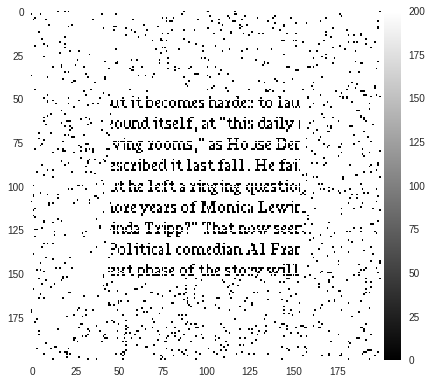

Finished in 235.807328939 seconds


/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /content/gdrive/My Drive/Colab Notebooks/T4_9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


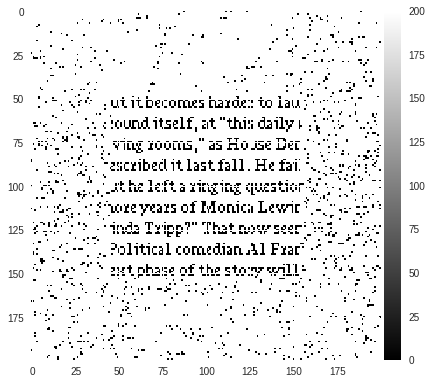

Finished in 314.42198801 seconds


/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /content/gdrive/My Drive/Colab Notebooks/T4_11.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


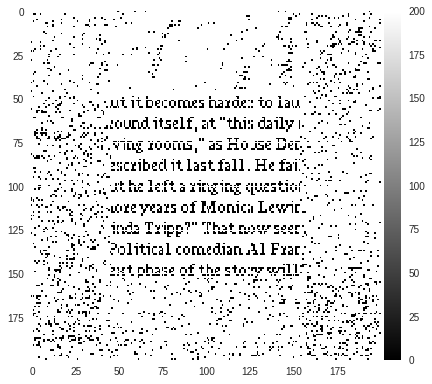

In [20]:

SampleImageList = ["T1.gif","T2.gif","T3.gif","T4.gif"]
#SampleImageList = ["T1.gif"]
filePath = "/content/gdrive/My Drive/Colab Notebooks/"

WindowSizeList = [5,9,11,15,17,21]
ErrThreshold = 0.1
MaxErrThreshold = 0.3



for i in range(len(SampleImageList)):
    for j in range(len(WindowSizeList)):
        SampleImage = io.imread(filePath+SampleImageList[i])
        SampleImage = SampleImage.astype(float)/255
        WindowSize = WindowSizeList[j]
        Sigma = WindowSize/6.4
        
        Image = np.zeros([200,200])
        is_filled = np.zeros([200,200])
        if SampleImage.shape[0] & 1:
            rx = 1
        else:
            rx = 0

        if SampleImage.shape[1] & 1:
            cx = 1
        else:
            cx = 0

        Image[Image.shape[0]/2-SampleImage.shape[0]/2:Image.shape[0]/2+SampleImage.shape[0]/2+rx, Image.shape[1]/2-SampleImage.shape[1]/2:Image.shape[1]/2+SampleImage.shape[1]/2 + cx] = SampleImage[:,:]

        is_filled[Image.shape[0]/2-SampleImage.shape[0]/2:Image.shape[0]/2+SampleImage.shape[0]/2+rx, Image.shape[1]/2-SampleImage.shape[1]/2:Image.shape[1]/2+SampleImage.shape[1]/2 + cx] = np.ones((SampleImage.shape[0], SampleImage.shape[1]))
        n = WindowSize/2
        paddedImage = cv2.copyMakeBorder(Image,n,n,n,n,cv2.BORDER_REFLECT)
        number_pixel = Image.shape[0]*Image.shape[1]
        number_filled = SampleImage.shape[0]*SampleImage.shape[1]

        start = time.time()

        OutputImage = GrowImage(SampleImage,Image,WindowSize)

        end = time.time()
        print ("Finished in "+str(end-start)+" seconds")

        OutputImage *= 255
        OutputImage = np.uint(OutputImage)
        io.imshow(OutputImage, cmap='gray')
        io.imsave(filePath+"T"+str(i)+"_"+str(WindowSize)+".jpg", OutputImage)
        io.show()

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
